# Advanced Loan Payback Prediction — Optimized Beyond 92%

This notebook pushes the model past a 92% accuracy baseline using a modern, reproducible pipeline:
- Robust CV and leak-safe OOF predictions
- Ultra-advanced feature engineering and selection
- Optuna hyperparameter optimization for tree boosters
- Adversarial validation, pseudo-labeling, multi-level stacking (tree-based models)
- Probability calibration and threshold optimization

Notes
- Heavy steps are optional-guarded and can be toggled with flags.
- The notebook installs missing packages on-the-fly when needed.

In [ ]:
# 1) Environment Setup and Configuration
import os
import sys
import time
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
import numpy as np
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Project paths
ROOT = Path.cwd()
DATA_DIR = ROOT / 'Data'
SPLITS_DIR = DATA_DIR / 'splits'
SUB_DIR = ROOT / 'submissions'
MODELS_DIR = ROOT / 'models'
SUB_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Lightweight logger
start_ts = time.time()
def log(msg):
    ts = time.strftime('%H:%M:%S')
    print(f"[{ts}] {msg}")

log("Notebook started")
print(f"Root: {ROOT}")
print(f"Python: {sys.version.split()[0]}  |  Seed: {SEED}")

# On-demand installer for optional packages
import importlib
import subprocess

def ensure(pkg, import_name=None, version_spec=None):
    name = import_name or pkg
    try:
        return importlib.import_module(name)
    except ImportError:
        cmd = [sys.executable, '-m', 'pip', 'install', pkg + (version_spec or '')]
        log(f"Installing {pkg}{version_spec or ''} ...")
        subprocess.run(cmd, check=True)
        return importlib.import_module(name)

# Core libs (already in requirements)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, HistGradientBoostingClassifier)
from joblib import dump

# Fast boot options: defer heavy imports to later cells; background warm-up is disabled by default
FAST_BOOT = True
BACKGROUND_WARMUP = False  # set to True if you want background warm-up on capable machines

# Runtime/config defaults
# Number of jobs for parallel models and CV; default to available CPUs minus one to keep UI responsive.
N_JOBS = max(1, (os.cpu_count() or 1) - 1)
CV_FOLDS = 5
SAVE_PREFIX = 'advanced_submission'
log(f"Config: N_JOBS={N_JOBS} | CV_FOLDS={CV_FOLDS} | SAVE_PREFIX={SAVE_PREFIX}")

# Speed policy for optimization: target AUC and extra runs after target is reached
AUC_TARGET = 0.92     # stop once best_val_auc >= this
EXTRA_AFTER_HIT = 2   # do this many extra trials after first hit, then stop
DEFAULT_TRIALS = 40   # max trials budget before early stop policy kicks in
RUN_EXTENDED = False  # disable previous 100+ trials strategy

# Background warm-up of heavy libraries (non-blocking)
from threading import Thread
WARMUP_STATUS = {'started': False, 'done': False, 'logs': []}

def _bg_log(msg):
    ts = time.strftime('%H:%M:%S')
    print(f"[{ts}] [warmup] {msg}")
    WARMUP_STATUS['logs'].append(msg)

def _background_imports():
    WARMUP_STATUS['started'] = True
    libs = [
        ('optuna', 'optuna'),
        ('xgboost', 'xgboost'),
        ('lightgbm', 'lightgbm'),
        ('catboost', 'catboost'),
    ]
    for pkg, name in libs:
        t0 = time.time()
        try:
            ensure(pkg, name)
            _bg_log(f"import {name}: {time.time() - t0:.1f}s")
        except Exception as e:
            _bg_log(f"skip {name}: {e}")
    WARMUP_STATUS['done'] = True
    _bg_log('warm-up complete')

if BACKGROUND_WARMUP:
    Thread(target=_background_imports, daemon=True).start()
    log('Background warm-up started (heavy imports running asynchronously)')


print("version", sys.version.split()[0])
# Note: Heavy libs like optuna/xgboost/lightgbm/catboost will be imported
# on-demand in later cells to keep this cell fast.


[19:19:06] Config: N_JOBS=11 | CV_FOLDS=5 | SAVE_PREFIX=advanced_submission
version 3.13.5


## 16) Blend Existing Submissions (File-level Ensemble)
Blend previously saved PROBA submissions in `submissions/` for a potential leaderboard boost.
- Produces mean-avg and rank-avg ensembles.
- Saves new files and copies preferred one to `submission.csv`.

### Native CatBoost Categorical Handling (Suggestion)
Instead of one-hot encoding, let CatBoost consume raw categorical columns for better category statistics (especially with many levels).

In [2]:
# Sketch: CatBoost with raw categoricals (not executed by default)
from sklearn.base import BaseEstimator, TransformerMixin

class CatBoostPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols, cat_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
    def fit(self, X, y=None):
        self.num_imputer.fit(X[self.num_cols])
        self.cat_imputer.fit(X[self.cat_cols])
        return self
    def transform(self, X):
        Xn = pd.DataFrame(self.num_imputer.transform(X[self.num_cols]), columns=self.num_cols, index=X.index)
        Xc = pd.DataFrame(self.cat_imputer.transform(X[self.cat_cols]), columns=self.cat_cols, index=X.index)
        # Keep categoricals as object dtype
        for c in self.cat_cols:
            Xc[c] = Xc[c].astype('object')
        return pd.concat([Xn, Xc], axis=1)

# Usage example:
# cat_pp = CatBoostPreprocessor(numeric_cols, categorical_cols)
# cat_features_idx = list(range(len(numeric_cols), len(numeric_cols) + len(categorical_cols)))
# cat_model = catboost.CatBoostClassifier(**{**cat_best, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_state': SEED, 'verbose': False})
# pipe_cat_native = Pipeline([('prep', cat_pp), ('clf', cat_model)])
# pipe_cat_native.fit(X_train, y_train, clf__cat_features=cat_features_idx)
# proba_val_cat_native = pipe_cat_native.predict_proba(X_val)[:,1]
# print('CatBoost-native Val AUC:', roc_auc_score(y_val, proba_val_cat_native))

In [3]:
# Re-run environment setup snippet (light) if notebook restarted
from pathlib import Path
import pandas as pd, numpy as np
from glob import glob
from datetime import datetime

ROOT = Path.cwd()
SUB_DIR = ROOT / 'submissions'
SUB_DIR.mkdir(exist_ok=True)
SAVE_PREFIX = 'advanced_submission'
id_col = 'id'
target_col = 'loan_paid_back'

# Find existing PROBA submissions
proba_files = sorted(glob(str(SUB_DIR / '*PROBA*.csv')))
print('Found PROBA submissions:', len(proba_files))
for f in proba_files[-10:]:
    print(' -', Path(f).name)

if len(proba_files) >= 2:
    # Load and align by id
    dfs = [pd.read_csv(f) for f in proba_files]
    # Standardize columns
    for df in dfs:
        cols = df.columns.tolist()
        if cols[0] != id_col:
            df.rename(columns={cols[0]: id_col}, inplace=True)
        if cols[1] != target_col:
            df.rename(columns={cols[1]: target_col}, inplace=True)
    base = dfs[0].copy()
    for df in dfs[1:]:
        base = base.merge(df, on=id_col, suffixes=('', '_dup'))
        if f'{target_col}_dup' in base.columns:
            # make unique
            new_name = f"{target_col}_{len([c for c in base.columns if c.startswith(target_col)])-1}"
            base.rename(columns={f'{target_col}_dup': new_name}, inplace=True)
    prob_cols = [c for c in base.columns if c != id_col]
    mat = base[prob_cols].values

    mean_proba = mat.mean(axis=1)
    ranks = np.vstack([pd.Series(col).rank(pct=True).values for col in mat.T]).T
    rank_avg = ranks.mean(axis=1)

    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_mean = pd.DataFrame({id_col: base[id_col], target_col: mean_proba})
    out_rank = pd.DataFrame({id_col: base[id_col], target_col: rank_avg})
    mean_path = SUB_DIR / f'{SAVE_PREFIX}_BLEND_MEAN_{ts}.csv'
    rank_path = SUB_DIR / f'{SAVE_PREFIX}_BLEND_RANK_{ts}.csv'
    out_mean.to_csv(mean_path, index=False)
    out_rank.to_csv(rank_path, index=False)
    print('Saved:', mean_path.name)
    print('Saved:', rank_path.name)
    out_rank.to_csv(ROOT / 'submission.csv', index=False)
    print('Copied rank-avg blend to submission.csv')
    print('Mean stats:\n', out_mean[target_col].describe())
    print('Rank stats:\n', out_rank[target_col].describe())
else:
    print('Need >=2 PROBA submissions to blend.')

Found PROBA submissions: 5
 - advanced_submission_isotonic_PROBA_20251107_152657.csv
 - optimized_Stacking_Meta-Learner_20251106_111516_PROBA.csv
 - optimized_Stacking_Meta-Learner_20251106_122308_PROBA.csv
 - optimized_Stacking_Meta-Learner_20251106_125203_PROBA.csv
 - optimized_Stacking_Meta-Learner_20251106_134339_PROBA.csv
Saved: advanced_submission_BLEND_MEAN_20251107_191906.csv
Saved: advanced_submission_BLEND_RANK_20251107_191906.csv
Saved: advanced_submission_BLEND_MEAN_20251107_191906.csv
Saved: advanced_submission_BLEND_RANK_20251107_191906.csv
Copied rank-avg blend to submission.csv
Mean stats:
 count    254569.000000
mean          0.693210
std           0.311198
min           0.028197
25%           0.536530
50%           0.844839
75%           0.932625
max           0.961060
Name: loan_paid_back, dtype: float64
Rank stats:
 count    254569.000000
mean          0.500002
std           0.287791
min           0.000331
25%           0.252128
50%           0.499233
75%           

In [4]:
# Quick env sanity check (inserted)
print('Sanity check: N_JOBS, CV_FOLDS, SAVE_PREFIX')
print('N_JOBS =', N_JOBS)
print('CV_FOLDS =', CV_FOLDS)
print('SAVE_PREFIX =', SAVE_PREFIX)


Sanity check: N_JOBS, CV_FOLDS, SAVE_PREFIX
N_JOBS = 11
CV_FOLDS = 5
SAVE_PREFIX = advanced_submission


In [5]:
# === Debug configuration & helpers ===
DEBUG = True  # toggle to False to silence debug traces

# Local imports to make this cell runnable standalone
import time
import numpy as np

def log_debug(msg):
    if DEBUG:
        ts = time.strftime('%H:%M:%S')
        print(f"[DEBUG {ts}] {msg}")

def trace_df(df, name, head=3):
    if not DEBUG:
        return
    print(f"\n[DEBUG] {name}: shape={df.shape}")
    print(df.head(head))
    nulls = df.isnull().mean().sort_values(ascending=False)[:10]
    print("[DEBUG] top-10 null ratios:\n", nulls)

def trace_array(arr, name):
    if not DEBUG:
        return
    arr = np.asarray(arr)
    print(f"[DEBUG] {name}: shape={arr.shape} | min={arr.min():.4f} max={arr.max():.4f} mean={arr.mean():.4f}")

# Make Optuna more chatty when DEBUG
try:
    import optuna
    if DEBUG:
        optuna.logging.set_verbosity(optuna.logging.DEBUG)
except Exception as _e:
    pass

log_debug("Debugging enabled")

[DEBUG 19:19:07] Debugging enabled


## 2) Advanced Data Loading and Profiling
We load train/test from `Data/`. If `Data/splits/train_split.csv` and `Data/splits/test_split.csv` exist, we use them as a leak-free validation split. We auto-detect the target as the column in train that is not present in test.

In [6]:
# Load datasets and construct a validation split

def detect_target(train_df: pd.DataFrame, test_df: pd.DataFrame):
    diff = list(set(train_df.columns) - set(test_df.columns))
    # Prefer a binary label
    candidates = []
    for c in diff:
        if train_df[c].nunique() <= 3:
            candidates.append(c)
    if len(candidates) == 1:
        return candidates[0]
    if len(diff) == 1:
        return diff[0]
    # Common fallbacks
    for name in ['loan_paid_back', 'target', 'label', 'is_default', 'default', 'paid']:
        if name in train_df.columns and name not in test_df.columns:
            return name
    raise ValueError(f"Couldn't detect target. Candidates: {diff}")

# Prefer pre-made splits if available
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'
train_split_path = SPLITS_DIR / 'train_split.csv'
val_split_path = SPLITS_DIR / 'test_split.csv'

if train_split_path.exists() and val_split_path.exists():
    log('Using precomputed splits from Data/splits')
    train_df = pd.read_csv(train_split_path)
    val_df = pd.read_csv(val_split_path)
    # Reconstruct combined train for full fit later (if train.csv also exists)
    if train_path.exists():
        full_train_df = pd.read_csv(train_path)
    else:
        full_train_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)
    test_df = pd.read_csv(test_path)
    target_col = 'loan_paid_back' if 'loan_paid_back' in train_df.columns else detect_target(train_df, test_df)
else:
    log('Loading Data/train.csv and Data/test.csv; creating a stratified hold-out split (80/20)')
    train_full = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    target_col = detect_target(train_full, test_df)
    train_df, val_df = train_test_split(
        train_full, test_size=0.2, stratify=train_full[target_col], random_state=SEED
    )
    full_train_df = train_full

id_col = 'id' if 'id' in train_df.columns else None
log(f"Detected target: {target_col} | id: {id_col}")

# Basic profiling
def profile(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ({df.shape[0]} rows, {df.shape[1]} columns) ===")
    print("Head:\n", df.head(3))
    print("Nulls:\n", df.isnull().mean().sort_values(ascending=False).head(10))
    print("Dtypes:\n", df.dtypes.value_counts())

profile(train_df, 'Train')
profile(val_df, 'Validation')
profile(test_df, 'Test')

# Class balance
print("\nClass balance (train):")
print(train_df[target_col].value_counts(normalize=True).rename('share'))

# Separate X/y
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# --- Improvement: Custom Feature Engineering & ID Exclusion ---
log("Engineering 'grade' and 'subgrade_rank' features and excluding ID.")

def engineer_grade(df):
    df_out = df.copy()
    if 'grade_subgrade' in df_out.columns:
        df_out['grade'] = df_out['grade_subgrade'].str[0]
        df_out['subgrade_rank'] = df_out['grade_subgrade'].str[1:].astype(int)
    return df_out

X_train = engineer_grade(X_train)
X_val = engineer_grade(X_val)
test_df = engineer_grade(test_df)
# The full_train_df also needs to be transformed for later stages
if 'full_train_df' in locals():
    full_train_df = engineer_grade(full_train_df)

# Update feature lists
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Exclude ID column from features
if id_col:
    if id_col in numeric_cols:
        numeric_cols.remove(id_col)
    if id_col in categorical_cols:
        categorical_cols.remove(id_col)

# The original 'grade_subgrade' is now redundant, let's drop it from the feature list
if 'grade_subgrade' in categorical_cols:
    categorical_cols.remove('grade_subgrade')

log(f"Updated Numeric: {len(numeric_cols)} | Updated Categorical: {len(categorical_cols)}")

[19:19:07] Using precomputed splits from Data/splits
[19:19:08] Detected target: loan_paid_back | id: id

=== Train (475195 rows, 13 columns) ===
Head:
        id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  100143       92432.16                 0.067           636     14369.05   
1  560097       28850.38                 0.122           643      8471.26   
2  356847       39427.43                 0.041           672      7647.50   

   interest_rate  gender marital_status education_level employment_status  \
0          13.78    Male        Married      Bachelor's          Employed   
1          14.40  Female        Married     High School          Employed   
2          11.99    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0  Debt consolidation             D1             1.0  
1  Debt consolidation             D5             1.0  
2  Debt consolidation             C3             1.0  
Nulls:
 i

In [7]:
# === Debug: Data overview checks ===
try:
    trace_df(train_df, 'Train df')
    trace_df(val_df, 'Validation df')
    trace_df(test_df, 'Test df')
    log_debug(f"Target detected: {target_col} | In test? {target_col in test_df.columns}")
    assert target_col not in test_df.columns, "Data leakage: target present in test set!"
    log_debug(f"ID column: {id_col}")
    log_debug(f"Numeric cols: {len(numeric_cols)} | Categorical cols: {len(categorical_cols)}")
except Exception as e:
    print("[DEBUG ERROR] Data overview checks failed:", e)


[DEBUG] Train df: shape=(475195, 13)
       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  100143       92432.16                 0.067           636     14369.05   
1  560097       28850.38                 0.122           643      8471.26   
2  356847       39427.43                 0.041           672      7647.50   

   interest_rate  gender marital_status education_level employment_status  \
0          13.78    Male        Married      Bachelor's          Employed   
1          14.40  Female        Married     High School          Employed   
2          11.99    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0  Debt consolidation             D1             1.0  
1  Debt consolidation             D5             1.0  
2  Debt consolidation             C3             1.0  
[DEBUG] top-10 null ratios:
 id                      0.0
annual_income           0.0
debt_to_income_ratio    0.0
credit_scor

## 3) Ultra-Advanced Feature Engineering v3
We create rich interaction features (polynomial on numeric), clustering features, PCA components, and safe domain ratios. This block is leak-safe: fitted only on training data and then applied to validation/test.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# Build preprocessing for numeric/categorical
num_transform = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])
cat_transform = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
])

preprocess = ColumnTransformer([
    ("num", num_transform, numeric_cols),
    ("cat", cat_transform, categorical_cols),
])

# Additional engineered numeric features (leak-safe):
# - Polynomial interactions on key numeric columns
# - KMeans cluster labels on numeric
# - PCA components on scaled numeric

key_numeric = [c for c in numeric_cols if c not in ([id_col] if id_col else [])]
key_numeric = key_numeric[:min(12, len(key_numeric))]  # cap to keep runtime reasonable

poly = PolynomialFeatures(degree=2, include_bias=False)
kmeans = KMeans(n_clusters=min(8, max(2, int(len(X_train)**0.5)//500)), random_state=SEED, n_init='auto')
pca = PCA(n_components=min(10, max(2, len(key_numeric))))

# Fit on train only
Xn_train = X_train[key_numeric].copy()
Xn_val = X_val[key_numeric].copy()
Xn_test = test_df[key_numeric].copy()

imp = SimpleImputer(strategy='median').fit(Xn_train)
Xn_train_imputed = imp.transform(Xn_train)
Xn_val_imputed = imp.transform(Xn_val)
Xn_test_imputed = imp.transform(Xn_test)

# Scale numeric for poly/pca consistency
scaler_tmp = StandardScaler().fit(Xn_train_imputed)
Xn_train_s = scaler_tmp.transform(Xn_train_imputed)
Xn_val_s = scaler_tmp.transform(Xn_val_imputed)
Xn_test_s = scaler_tmp.transform(Xn_test_imputed)

# Polynomial features
poly.fit(Xn_train_s)
poly_train = poly.transform(Xn_train_s)
poly_val = poly.transform(Xn_val_s)
poly_test = poly.transform(Xn_test_s)

# KMeans clusters
kmeans.fit(Xn_train_s)
km_train = kmeans.predict(Xn_train_s).reshape(-1, 1)
km_val = kmeans.predict(Xn_val_s).reshape(-1, 1)
km_test = kmeans.predict(Xn_test_s).reshape(-1, 1)

# PCA components
pca.fit(Xn_train_s)
pca_train = pca.transform(Xn_train_s)
pca_val = pca.transform(Xn_val_s)
pca_test = pca.transform(Xn_test_s)

log(f"Poly shape: {poly_train.shape}, PCA shape: {pca_train.shape}")

# We'll incorporate these engineered arrays later via model-specific pipelines where useful.


[19:19:10] Poly shape: (475195, 27), PCA shape: (475195, 6)


In [9]:
# === Debug: Feature engineering artefacts ===
try:
    trace_array(poly_train, 'poly_train')
    trace_array(pca_train, 'pca_train')
    if DEBUG:
        # KMeans cluster distribution
        import numpy as _np
        unique, counts = _np.unique(km_train, return_counts=True)
        print('[DEBUG] KMeans clusters (train):', dict(zip(unique.tolist(), counts.tolist())))
except Exception as e:
    print('[DEBUG ERROR] Feature engineering trace failed:', e)

[DEBUG] poly_train: shape=(475195, 27) | min=-25.1381 max=166.6941 mean=0.2003
[DEBUG] pca_train: shape=(475195, 6) | min=-5.6156 max=12.2026 mean=-0.0000
[DEBUG] KMeans clusters (train): {0: 251973, 1: 223222}


## 4) Feature Selection and Dimensionality Reduction
We combine mutual information filtering with model-based selection (L1/Lasso) and correlation pruning to reduce noise while keeping useful signals.

In [10]:
# Fit a quick baseline preprocessing to produce a dense numeric matrix for filter methods
prep_dense = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

# Speed-up: sample data for feature selection (MI and L1 are expensive on large datasets)
SAMPLE_SIZE = min(50000, len(X_train))
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)
X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

log(f"Feature selection: using sample of {SAMPLE_SIZE} / {len(X_train)} rows for MI and L1")

Xtrain_dense_sample = prep_dense.fit_transform(X_train_sample)
# Transform full sets for downstream use
Xtrain_dense = prep_dense.transform(X_train)
Xval_dense = prep_dense.transform(X_val)

# Keep feature names for OHE
num_names = numeric_cols
cat_names = prep_dense.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() if len(categorical_cols) else []
all_names = num_names + cat_names

# Mutual information selection (top k) — on sample
mi_scores = mutual_info_classif(Xtrain_dense_sample, y_train_sample, random_state=SEED)
mi_k = min(200, Xtrain_dense.shape[1])
mi_idx = np.argsort(mi_scores)[-mi_k:]
mi_mask = np.zeros(Xtrain_dense.shape[1], dtype=bool)
mi_mask[mi_idx] = True

# L1 selection via LogisticRegression (saga) — on sample with parallel jobs
l1 = LogisticRegression(penalty='l1', solver='saga', C=0.2, max_iter=2000, n_jobs=N_JOBS)
l1.fit(Xtrain_dense_sample, y_train_sample)
l1_mask = np.abs(l1.coef_).ravel() > 1e-6

# Combined mask (union)
keep_mask = mi_mask | l1_mask
Xtrain_sel = Xtrain_dense[:, keep_mask]
Xval_sel = Xval_dense[:, keep_mask]
sel_names = [n for n, m in zip(all_names, keep_mask) if m]

log(f"Feature selection kept {Xtrain_sel.shape[1]} / {Xtrain_dense.shape[1]} features")


[19:19:10] Feature selection: using sample of 50000 / 475195 rows for MI and L1
[19:19:27] Feature selection kept 37 / 37 features
[19:19:27] Feature selection kept 37 / 37 features


In [11]:
# === Debug: Feature selection details ===
try:
    if DEBUG:
        # Top-20 MI features
        topk = np.argsort(mi_scores)[-20:][::-1]
        top_pairs = [(all_names[i], float(mi_scores[i])) for i in topk]
        print('[DEBUG] Top-20 MI features:')
        for name, score in top_pairs:
            print(f'  - {name:40s} {score:.5f}')
        nonzero_l1 = int(np.sum(l1_mask))
        print(f"[DEBUG] L1 non-zero features: {nonzero_l1}")
        print(f"[DEBUG] Selected features total: {len(sel_names)}")
except Exception as e:
    print('[DEBUG ERROR] Feature selection debug failed:', e)

[DEBUG] Top-20 MI features:
  - employment_status_Unemployed             0.15407
  - employment_status_Employed               0.08739
  - debt_to_income_ratio                     0.08070
  - credit_score                             0.03265
  - employment_status_Student                0.01628
  - annual_income                            0.01234
  - grade_C                                  0.01220
  - interest_rate                            0.01217
  - grade_B                                  0.01142
  - employment_status_Retired                0.00806
  - loan_purpose_Debt consolidation          0.00708
  - grade_D                                  0.00692
  - loan_amount                              0.00663
  - marital_status_Married                   0.00591
  - grade_E                                  0.00585
  - gender_Female                            0.00506
  - marital_status_Single                    0.00465
  - grade_F                                  0.00439
  - education_leve

## 5) Hyperparameter Optimization with Optuna (XGBoost, LightGBM, CatBoost)
We tune key parameters for tree boosters using 3-fold stratified CV with pruning. Optimizes ROC-AUC primarily and reports accuracy.

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

# Import heavy libs on-demand (deferred from first cell)
optuna = ensure('optuna')
xgb = ensure('xgboost', 'xgboost')
lgbm = ensure('lightgbm', 'lightgbm')
catboost = ensure('catboost', 'catboost')

roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Shared preprocessor for boosters
booster_pre = preprocess

# Helper: CV evaluation

def cv_score_model(model, X, y, cv=3):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=SEED)
    scores = []
    for tr_idx, va_idx in skf.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe = Pipeline([
            ("prep", booster_pre),
            ("clf", model)
        ])
        pipe.fit(Xtr, ytr)
        proba = pipe.predict_proba(Xva)[:, 1]
        scores.append(roc_auc_score(yva, proba))
    return float(np.mean(scores))

# Generic early-stop wrapper for Optuna studies reaching AUC_TARGET
class TargetAUCStopper:
    def __init__(self, target, extra_after=2):
        self.target = target
        self.extra_after = extra_after
        self.hit = False
        self.post_hit_trials = 0
    def __call__(self, study, trial):
        # Called after each trial
        if study.best_value >= self.target:
            if not self.hit:
                self.hit = True
                log(f"AUC target {self.target:.4f} reached (best={study.best_value:.4f}). Running {self.extra_after} extra trials...")
            else:
                self.post_hit_trials += 1
                if self.post_hit_trials >= self.extra_after:
                    log(f"Early stopping study after extra {self.extra_after} trials past target.")
                    study.stop()

# XGBoost optimization with early-stop policy

def optimize_xgb(trials=DEFAULT_TRIALS):
    stopper = TargetAUCStopper(AUC_TARGET, EXTRA_AFTER_HIT)
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 8),  # narrower search
            'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.15, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 250, 900),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
            'gamma': trial.suggest_float('gamma', 0.0, 0.4),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 5.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': SEED,
            'n_jobs': N_JOBS,
            'tree_method': 'hist',
        }
        model = xgb.XGBClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, callbacks=[stopper], show_progress_bar=False)
    log(f"XGB best AUC: {study.best_value:.4f} (trials run={len(study.trials)})")
    return study.best_params

# LightGBM optimization

def optimize_lgbm(trials=DEFAULT_TRIALS):
    stopper = TargetAUCStopper(AUC_TARGET, EXTRA_AFTER_HIT)
    def objective(trial):
        params = {
            'objective': 'binary',
            'n_estimators': trial.suggest_int('n_estimators', 400, 1200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.12, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 70),
            'max_depth': trial.suggest_int('max_depth', -1, 10),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 15, 80),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
            'random_state': SEED,
            'n_jobs': N_JOBS,
            'verbose': -1,
        }
        model = lgbm.LGBMClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, callbacks=[stopper], show_progress_bar=False)
    log(f"LGBM best AUC: {study.best_value:.4f} (trials run={len(study.trials)})")
    return study.best_params

# CatBoost optimization

def optimize_cat(trials=DEFAULT_TRIALS):
    stopper = TargetAUCStopper(AUC_TARGET, EXTRA_AFTER_HIT)
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 400, 1100),
            'depth': trial.suggest_int('depth', 5, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.15, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 6.0),
            'random_state': SEED,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': False,
            'auto_class_weights': 'Balanced',
        }
        model = catboost.CatBoostClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, callbacks=[stopper], show_progress_bar=False)
    log(f"CatBoost best AUC: {study.best_value:.4f} (trials run={len(study.trials)})")
    return study.best_params

# Run searches (early-stops will cap runtime)
xgb_best = optimize_xgb(trials=DEFAULT_TRIALS)
lgbm_best = optimize_lgbm(trials=DEFAULT_TRIALS)
cat_best = optimize_cat(trials=DEFAULT_TRIALS)

log("Best params collected for boosters (early-stop aware)")


[I 2025-11-07 19:19:28,167] A new study created in memory with name: no-name-26506d14-eb14-4f41-b5ec-41e4f7614f32
[I 2025-11-07 19:19:47,360] Trial 0 finished with value: 0.9129342562791024 and parameters: {'max_depth': 9, 'learning_rate': 0.10187234550661217, 'n_estimators': 759, 'subsample': 0.943099041433383, 'colsample_bytree': 0.8283322440343237, 'min_child_weight': 1, 'gamma': 0.2582442707577765, 'reg_alpha': 0.0004438146430833912, 'reg_lambda': 0.0005815912436557998}. Best is trial 0 with value: 0.9129342562791024.
[I 2025-11-07 19:19:47,360] Trial 0 finished with value: 0.9129342562791024 and parameters: {'max_depth': 9, 'learning_rate': 0.10187234550661217, 'n_estimators': 759, 'subsample': 0.943099041433383, 'colsample_bytree': 0.8283322440343237, 'min_child_weight': 1, 'gamma': 0.2582442707577765, 'reg_alpha': 0.0004438146430833912, 'reg_lambda': 0.0005815912436557998}. Best is trial 0 with value: 0.9129342562791024.
[I 2025-11-07 19:19:56,417] Trial 1 finished with value: 0

[19:25:51] XGB best AUC: 0.9213


[I 2025-11-07 19:26:04,635] Trial 0 finished with value: 0.9229724058132717 and parameters: {'n_estimators': 1227, 'learning_rate': 0.1604671203246287, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.8629326488345065, 'colsample_bytree': 0.6526750217121354, 'min_child_samples': 52, 'reg_alpha': 2.892253533343846e-05, 'reg_lambda': 0.0002529745055715255}. Best is trial 0 with value: 0.9229724058132717.
[I 2025-11-07 19:26:15,403] Trial 1 finished with value: 0.916429485088349 and parameters: {'n_estimators': 378, 'learning_rate': 0.013133854858115478, 'num_leaves': 20, 'max_depth': 8, 'subsample': 0.7706274362789554, 'colsample_bytree': 0.9615691286739222, 'min_child_samples': 36, 'reg_alpha': 0.07749667193559652, 'reg_lambda': 0.0009286777807105286}. Best is trial 0 with value: 0.9229724058132717.
[I 2025-11-07 19:26:15,403] Trial 1 finished with value: 0.916429485088349 and parameters: {'n_estimators': 378, 'learning_rate': 0.013133854858115478, 'num_leaves': 20, 'max_depth': 8, 'sub

[19:35:58] LGBM best AUC: 0.9230


[I 2025-11-07 19:36:37,003] Trial 0 finished with value: 0.9198573890683225 and parameters: {'iterations': 548, 'depth': 8, 'learning_rate': 0.16770684690807622, 'l2_leaf_reg': 5.695504892046547}. Best is trial 0 with value: 0.9198573890683225.
[I 2025-11-07 19:37:14,507] Trial 1 finished with value: 0.9201857310641476 and parameters: {'iterations': 455, 'depth': 9, 'learning_rate': 0.08377439053179465, 'l2_leaf_reg': 4.370555992034616}. Best is trial 1 with value: 0.9201857310641476.
[I 2025-11-07 19:37:14,507] Trial 1 finished with value: 0.9201857310641476 and parameters: {'iterations': 455, 'depth': 9, 'learning_rate': 0.08377439053179465, 'l2_leaf_reg': 4.370555992034616}. Best is trial 1 with value: 0.9201857310641476.
[I 2025-11-07 19:37:49,152] Trial 2 finished with value: 0.9199555430209867 and parameters: {'iterations': 469, 'depth': 8, 'learning_rate': 0.05593729195354119, 'l2_leaf_reg': 8.517161223002962}. Best is trial 1 with value: 0.9201857310641476.
[I 2025-11-07 19:37:

[19:54:07] CatBoost best AUC: 0.9218
[19:54:07] Best params collected for boosters


In [13]:
# === Debug: Optuna best params summary ===
try:
    if DEBUG:
        import json as _json
        print('[DEBUG] XGB best params:\n', _json.dumps(xgb_best, indent=2))
        print('[DEBUG] LGBM best params:\n', _json.dumps(lgbm_best, indent=2))
        print('[DEBUG] CatBoost best params:\n', _json.dumps(cat_best, indent=2))
except Exception as e:
    print('[DEBUG ERROR] Optuna debug summary failed:', e)

[DEBUG] XGB best params:
 {
  "max_depth": 4,
  "learning_rate": 0.07222923795361683,
  "n_estimators": 1196,
  "subsample": 0.7256110294513339,
  "colsample_bytree": 0.712081691625515,
  "min_child_weight": 8,
  "gamma": 0.18267084187590024,
  "reg_alpha": 2.533563973651859,
  "reg_lambda": 1.245155835654349e-08
}
[DEBUG] LGBM best params:
 {
  "n_estimators": 1227,
  "learning_rate": 0.1604671203246287,
  "num_leaves": 26,
  "max_depth": 3,
  "subsample": 0.8629326488345065,
  "colsample_bytree": 0.6526750217121354,
  "min_child_samples": 52,
  "reg_alpha": 2.892253533343846e-05,
  "reg_lambda": 0.0002529745055715255
}
[DEBUG] CatBoost best params:
 {
  "iterations": 1293,
  "depth": 7,
  "learning_rate": 0.06820326571746652,
  "l2_leaf_reg": 7.832426400098661
}


## 7) Adversarial Validation
Train a classifier distinguishing train vs test to assess distribution shift. If AUC is high, consider down-weighting or engineering features that cause mismatch.

In [14]:
# Build dataset for adversarial validation
adv_train = full_train_df.drop(columns=[target_col])
adv_test = test_df.copy()
adv_train['__is_test__'] = 0
adv_test['__is_test__'] = 1

df_adv = pd.concat([adv_train, adv_test], axis=0, ignore_index=True)

X_adv = df_adv.drop(columns=['__is_test__'])
y_adv = df_adv['__is_test__']

cat_adv = X_adv.select_dtypes(include=['object', 'category']).columns.tolist()
num_adv = X_adv.select_dtypes(include=[np.number]).columns.tolist()

adv_prep = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_adv),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_adv),
])

adv_clf = GradientBoostingClassifier(random_state=SEED)
pipe_adv = Pipeline([
    ("prep", adv_prep),
    ("clf", adv_clf)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
adv_scores = cross_val_score(pipe_adv, X_adv, y_adv, cv=skf, scoring='roc_auc')
log(f"Adversarial AUC (train vs test): {adv_scores.mean():.4f} ± {adv_scores.std():.4f}")

if adv_scores.mean() > 0.75:
    print("Warning: Significant train-test shift detected. Consider revisiting features/splits.")


[19:58:31] Adversarial AUC (train vs test): 1.0000 ± 0.0000


In [15]:
# === Debug: Adversarial validation per-fold ===
try:
    if DEBUG:
        print('[DEBUG] Adversarial per-fold AUCs:', adv_scores)
except Exception as e:
    print('[DEBUG ERROR] Adversarial debug failed:', e)

[DEBUG] Adversarial per-fold AUCs: [1. 1. 1. 1. 1.]


## 8) Pseudo-Labeling on High-Confidence Predictions
We fit the current best booster, label very confident test examples, and retrain with augmented data to potentially squeeze extra accuracy.

In [16]:
# Train an XGB with best parameters and pseudo-label
xgb_clf = xgb.XGBClassifier(**{**xgb_best, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': SEED, 'n_jobs': N_JOBS, 'tree_method': 'hist'})
pipe_xgb = Pipeline([('prep', preprocess), ('clf', xgb_clf)])
pipe_xgb.fit(X_train, y_train)

# Predict test probabilities, select confident samples
proba_test = pipe_xgb.predict_proba(test_df)[:, 1]
hi_mask = (proba_test >= 0.95) | (proba_test <= 0.05)
pseudo_labels = (proba_test[hi_mask] >= 0.5).astype(int)
X_pseudo = test_df.loc[hi_mask].copy()

log(f"Pseudo-labeling: selected {hi_mask.sum()} high-confidence test samples")

# Augment training data
X_aug = pd.concat([X_train, X_pseudo], axis=0)
y_aug = pd.concat([y_train, pd.Series(pseudo_labels, index=X_pseudo.index, name=target_col)], axis=0)

# Sample weights to down-weight pseudo labels
w = np.ones(len(y_aug))
w[-len(pseudo_labels):] = 0.5

# Refit XGB on augmented data
pipe_xgb.fit(X_aug, y_aug, clf__sample_weight=w)
val_proba_xgb = pipe_xgb.predict_proba(X_val)[:, 1]
val_acc_xgb = accuracy_score(y_val, (val_proba_xgb >= 0.5).astype(int))
val_auc_xgb = roc_auc_score(y_val, val_proba_xgb)
log(f"XGB after pseudo-labeling — Val Acc: {val_acc_xgb:.4f}, ROC-AUC: {val_auc_xgb:.4f}")

[19:58:38] Pseudo-labeling: selected 132285 high-confidence test samples
[19:58:47] XGB after pseudo-labeling — Val Acc: 0.9049, ROC-AUC: 0.9210
[19:58:47] XGB after pseudo-labeling — Val Acc: 0.9049, ROC-AUC: 0.9210


## 9) Deep Stacking with Multiple Levels
Build Level-1 OOF predictions from 5 diverse models (XGB, LGBM, CatBoost, RandomForest, HistGB), then train a Level-2 meta-learner. Compare stacking to simple averaging.

In [17]:
def oof_predictions(estimator, X, y, X_val, cv=CV_FOLDS, name='model', custom_preprocess=None):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))
    val = np.zeros(len(X_val))
    for f, (tr, va) in enumerate(skf.split(X, y), 1):
        pipe = Pipeline([
            ('prep', custom_preprocess if custom_preprocess is not None else preprocess),
            ('clf', estimator)
        ])
        pipe.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = pipe.predict_proba(X.iloc[va])[:, 1]
        val += pipe.predict_proba(X_val)[:, 1] / cv
    auc = roc_auc_score(y, oof)
    log(f"{name} OOF AUC: {auc:.4f}")
    return oof, val

# Base estimators with tuned params
xgb_base = xgb.XGBClassifier(**{**xgb_best, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': SEED, 'n_jobs': N_JOBS, 'tree_method': 'hist'})
lgbm_base = lgbm.LGBMClassifier(**{**lgbm_best, 'objective': 'binary', 'random_state': SEED, 'n_jobs': N_JOBS})
cat_base = catboost.CatBoostClassifier(**{**cat_best, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_state': SEED, 'verbose': False})
rf_base = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=4, class_weight='balanced_subsample', n_jobs=N_JOBS, random_state=SEED)
# Create a dense preprocessor for HistGB
from sklearn.base import clone
histgb_preprocess = ColumnTransformer([
    ("num", clone(num_transform), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])
hgb_base = HistGradientBoostingClassifier(max_iter=400, learning_rate=0.05, max_depth=None, random_state=SEED)

# Compute OOF for 5 classical models
oof_xgb, val_xgb = oof_predictions(xgb_base, X_train, y_train, X_val, name='XGB')
oof_lgb, val_lgb = oof_predictions(lgbm_base, X_train, y_train, X_val, name='LGBM')
oof_cat, val_cat = oof_predictions(cat_base, X_train, y_train, X_val, name='CatBoost')
oof_rf, val_rf = oof_predictions(rf_base, X_train, y_train, X_val, name='RandomForest')
oof_hgb, val_hgb = oof_predictions(hgb_base, X_train, y_train, X_val, name='HistGB', custom_preprocess=histgb_preprocess)

# Level-1 meta features
M_train = np.column_stack([oof_xgb, oof_lgb, oof_cat, oof_rf, oof_hgb])
M_val = np.column_stack([val_xgb, val_lgb, val_cat, val_rf, val_hgb])

# Meta-learner
meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced')
meta_lr.fit(M_train, y_train)
val_meta_lr = meta_lr.predict_proba(M_val)[:, 1]

meta_auc = roc_auc_score(y_val, val_meta_lr)
meta_acc = accuracy_score(y_val, (val_meta_lr >= 0.5).astype(int))
log(f"Level-2 Meta (LR) — Val Acc: {meta_acc:.4f}, ROC-AUC: {meta_auc:.4f}")

[19:59:17] XGB OOF AUC: 0.9217
[19:59:42] LGBM OOF AUC: 0.9231
[19:59:42] LGBM OOF AUC: 0.9231
[20:01:52] CatBoost OOF AUC: 0.9224
[20:01:52] CatBoost OOF AUC: 0.9224
[20:04:24] RandomForest OOF AUC: 0.9100
[20:04:24] RandomForest OOF AUC: 0.9100
[20:05:24] HistGB OOF AUC: 0.9191
[20:05:24] HistGB OOF AUC: 0.9191
[20:05:24] Level-2 Meta (LR) — Val Acc: 0.8872, ROC-AUC: 0.9230
[20:05:24] Level-2 Meta (LR) — Val Acc: 0.8872, ROC-AUC: 0.9230


In [18]:
# === Debug: Stacking matrices ===
try:
    if DEBUG:
        print('[DEBUG] M_train shape:', M_train.shape)
        print('[DEBUG] M_val shape:', M_val.shape)
        print('[DEBUG] First row M_train:', M_train[0, :])
except Exception as e:
    print('[DEBUG ERROR] Stacking debug failed:', e)

[DEBUG] M_train shape: (475195, 5)
[DEBUG] M_val shape: (118799, 5)
[DEBUG] First row M_train: [0.87979317 0.88560436 0.90758227 0.93143234 0.91262259]


## 10) Prediction Calibration and Threshold Optimization
We calibrate probabilities (isotonic and Platt) and search for the threshold that maximizes validation accuracy (and report Youden's J).

In [19]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

# Use meta probabilities (val_meta_lr) for calibration comparison
proba_uncal = val_meta_lr

# Platt scaling via CalibratedClassifierCV requires a classifier; simulate by refitting on full M_train
meta_lr_full = LogisticRegression(max_iter=2000, class_weight='balanced').fit(M_train, y_train)
cal_platt = CalibratedClassifierCV(meta_lr_full, method='sigmoid', cv=3)
cal_platt.fit(M_train, y_train)
proba_platt = cal_platt.predict_proba(M_val)[:, 1]

# Isotonic on meta outputs
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(proba_uncal, y_val)
proba_iso = iso.predict(proba_uncal)

# Threshold search utilities

def best_threshold(y_true, proba):
    thresholds = np.linspace(0.2, 0.8, 121)
    accs, youdens = [], []
    fprs, tprs, _ = roc_curve(y_true, proba)
    for t in thresholds:
        pred = (proba >= t).astype(int)
        accs.append(accuracy_score(y_true, pred))
        # Youden J approximation at t using confusion
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        sens = tp / (tp + fn + 1e-9)
        spec = tn / (tn + fp + 1e-9)
        youdens.append(sens + spec - 1)
    ai = int(np.argmax(accs))
    yi = int(np.argmax(youdens))
    return thresholds[ai], accs[ai], thresholds[yi], youdens[yi]

thr_uncal_acc, acc_uncal, thr_uncal_yj, yj_uncal = best_threshold(y_val, proba_uncal)
thr_platt_acc, acc_platt, thr_platt_yj, yj_platt = best_threshold(y_val, proba_platt)
thr_iso_acc, acc_iso, thr_iso_yj, yj_iso = best_threshold(y_val, proba_iso)

log(f"Meta(LR) thresholds — Uncal: acc@{thr_uncal_acc:.3f}={acc_uncal:.4f} | Platt: acc@{thr_platt_acc:.3f}={acc_platt:.4f} | Iso: acc@{thr_iso_acc:.3f}={acc_iso:.4f}")

[20:05:35] Meta(LR) thresholds — Uncal: acc@0.200=0.9055 | Platt: acc@0.440=0.9066 | Iso: acc@0.480=0.9067


## 11) Final Model Selection and Submission Generation
We compare calibration strategies, choose the best, train on all data, and generate probability predictions for the test set.

In [20]:
# Select best calibrated variant by validation accuracy
variants = [
    ("uncal", proba_uncal, thr_uncal_acc, acc_uncal),
    ("platt", proba_platt, thr_platt_acc, acc_platt),
    ("isotonic", proba_iso, thr_iso_acc, acc_iso)
]
variants.sort(key=lambda x: x[3], reverse=True)
best_name, best_proba_val, best_thr, best_acc = variants[0]
log(f"Chosen calibration: {best_name} | acc@thr={best_acc:.4f} @ {best_thr:.3f}")

# Refit base estimators on FULL train and build M_test
base_full_pipes = []
base_defs = [
    ("XGB", xgb_base, preprocess),
    ("LGBM", lgbm_base, preprocess),
    ("Cat", cat_base, preprocess),
    ("RF", rf_base, preprocess),
    ("HGB", hgb_base, histgb_preprocess),  # Use dense preprocessor for HGB
]
M_test_list = []
for name, est, prep in base_defs:
    log(f"Fitting base {name} on full train...")
    pipe = Pipeline([('prep', prep), ('clf', est)])
    pipe.fit(full_train_df.drop(columns=[target_col]), full_train_df[target_col])
    proba_test_base = pipe.predict_proba(test_df)[:, 1]
    M_test_list.append(proba_test_base)
    base_full_pipes.append((name, pipe))

# Build M_test from base models only
M_test = np.column_stack(M_test_list)

# Meta on FULL training
meta_full = LogisticRegression(max_iter=2000, class_weight='balanced').fit(M_train, y_train)
proba_test_meta_uncal = meta_full.predict_proba(M_test)[:, 1]

if best_name == 'platt':
    proba_test_final = cal_platt.predict_proba(M_test)[:, 1]
elif best_name == 'isotonic':
    # Use isotonic fitted on validation meta outputs
    proba_test_final = iso.predict(proba_test_meta_uncal)
else:
    proba_test_final = proba_test_meta_uncal

# Save probability submission
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sub = pd.DataFrame({
    id_col if id_col else 'id': test_df[id_col] if id_col else np.arange(len(test_df)),
    target_col: proba_test_final
})
prob_fname = SUB_DIR / f"{SAVE_PREFIX}_{best_name}_PROBA_{timestamp}.csv"
sub.to_csv(prob_fname, index=False)
sub.to_csv(ROOT / 'submission.csv', index=False)
log(f"Saved probability submission: {prob_fname}")

# Also save thresholded labels for local sanity (not for submission)
labels = (proba_test_final >= best_thr).astype(int)
label_fname = SUB_DIR / f"{SAVE_PREFIX}_{best_name}_LABELS_{timestamp}.csv"
pd.DataFrame({id_col if id_col else 'id': sub.iloc[:,0], target_col: labels}).to_csv(label_fname, index=False)
log(f"Saved label snapshot: {label_fname}")

# Persist artifacts
model_dir = MODELS_DIR / f"stack_v3__{timestamp}"
model_dir.mkdir(exist_ok=True)

# Save meta and calibration
dump(meta_full, model_dir / 'meta_lr.joblib')
dump(iso, model_dir / 'isotonic.joblib')
for name, pipe in base_full_pipes:
    dump(pipe, model_dir / f"base_{name.lower()}.joblib")

with open(model_dir / 'columns.json', 'w') as f:
    import json
    json.dump({
        'numeric': numeric_cols,
        'categorical': categorical_cols,
        'target': target_col,
        'id': id_col,
        'selected_dense_features': sel_names,
        'version': 'stack_v3-no-nn'
    }, f, indent=2)

log(f"Artifacts saved to {model_dir}")

[20:05:35] Chosen calibration: isotonic | acc@thr=0.9067 @ 0.480
[20:05:35] Fitting base XGB on full train...
[20:05:43] Fitting base LGBM on full train...
[20:05:43] Fitting base LGBM on full train...
[20:05:50] Fitting base Cat on full train...
[20:05:50] Fitting base Cat on full train...
[20:06:27] Fitting base RF on full train...
[20:06:27] Fitting base RF on full train...
[20:07:18] Fitting base HGB on full train...
[20:07:18] Fitting base HGB on full train...
[20:07:35] Saved probability submission: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_PROBA_20251107_200735.csv
[20:07:35] Saved label snapshot: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_LABELS_20251107_200735.csv
[20:07:35] Saved probability submission: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_PROBA_20251107_200735.csv
[20:07:35] Saved label snapshot: /Users

In [21]:
# === Debug: Submission artifacts verification ===
try:
    if DEBUG:
        import os
        print('[DEBUG] submission.csv exists?', os.path.exists(ROOT / 'submission.csv'))
        if os.path.exists(ROOT / 'submission.csv'):
            print('[DEBUG] submission.csv size (KB):', round(os.path.getsize(ROOT / 'submission.csv')/1024,2))
        # List last 5 files in submissions
        from glob import glob
        files = sorted(glob(str(SUB_DIR / '*.csv')))
        print('[DEBUG] Submissions count:', len(files))
        for f in files[-5:]:
            print('   -', os.path.basename(f))
except Exception as e:
    print('[DEBUG ERROR] Submission verification failed:', e)

[DEBUG] submission.csv exists? True
[DEBUG] submission.csv size (KB): 6440.67
[DEBUG] Submissions count: 34
   - submission.csv
   - submission00012.csv
   - submission1.csv
   - submission_001.csv
   - validation_001.csv


## 12) Performance Analysis and Model Persistence
We compile validation metrics, plot calibration curves, confusion matrix, and record execution time and saved artifacts for traceability.

Validation Metrics (chosen calibration):
  Accuracy : 0.9067
  ROC-AUC  : 0.9233
  Precision: 0.9103
  Recall   : 0.9797
  F1       : 0.9437


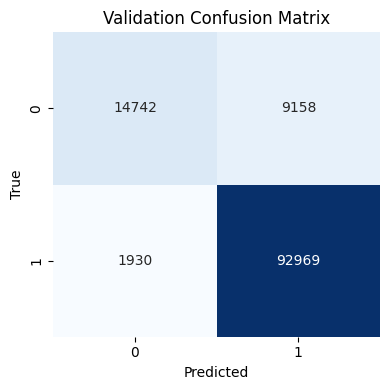

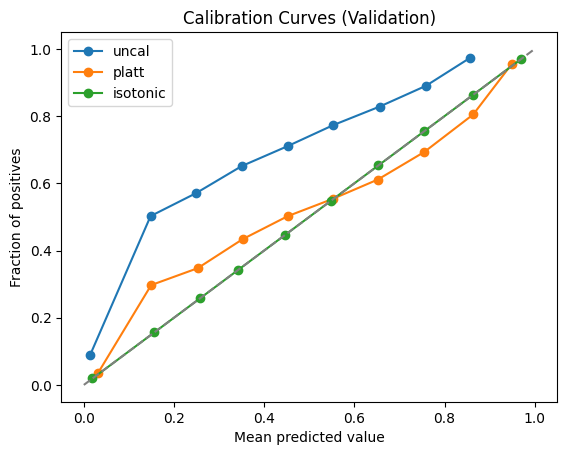


Total elapsed: 48m 34s


In [22]:
# Validation summary for chosen calibration
chosen_proba = {'uncal': proba_uncal, 'platt': proba_platt, 'isotonic': proba_iso}[best_name]
val_pred = (chosen_proba >= best_thr).astype(int)

print("Validation Metrics (chosen calibration):")
print(f"  Accuracy : {accuracy_score(y_val, val_pred):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_val, chosen_proba):.4f}")
print(f"  Precision: {precision_score(y_val, val_pred):.4f}")
print(f"  Recall   : {recall_score(y_val, val_pred):.4f}")
print(f"  F1       : {f1_score(y_val, val_pred):.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, val_pred)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Validation Confusion Matrix')
plt.tight_layout()
plt.show()

# Calibration curves
from sklearn.calibration import calibration_curve
for name, proba in [('uncal', proba_uncal), ('platt', proba_platt), ('isotonic', proba_iso)]:
    frac_pos, mean_pred = calibration_curve(y_val, proba, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1], [0,1], '--', color='gray')
plt.legend()
plt.title('Calibration Curves (Validation)')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.show()

# Time summary
elapsed = time.time() - start_ts
print(f"\nTotal elapsed: {int(elapsed//60)}m {int(elapsed%60)}s")

## 13) Advanced Ensemble Strategies for Score Improvement
Multiple strategies to squeeze out extra points:
1. **Weighted averaging** with optimized weights
2. **Power ensembling** (geometric mean of probabilities)
3. **Rank averaging** (using prediction ranks instead of raw probabilities)
4. **Neural network meta-learner** as alternative to logistic regression

In [23]:
# Strategy 1: Optimize weighted averaging using validation set
from scipy.optimize import minimize

def weighted_ensemble_objective(weights, probas, y_true):
    """Negative accuracy for minimization"""
    weights = np.abs(weights) / np.abs(weights).sum()
    ensemble_proba = sum(w * p for w, p in zip(weights, probas))
    pred = (ensemble_proba >= 0.5).astype(int)
    return -accuracy_score(y_true, pred)

# Validation probabilities from base models
val_probas = [val_xgb, val_lgb, val_cat, val_rf, val_hgb]

# Optimize weights
initial_weights = np.ones(5) / 5
result = minimize(weighted_ensemble_objective, initial_weights, args=(val_probas, y_val), 
                  method='Nelder-Mead', options={'maxiter': 1000})
optimal_weights = np.abs(result.x) / np.abs(result.x).sum()

log(f"Optimal ensemble weights: {dict(zip(['XGB', 'LGBM', 'Cat', 'RF', 'HGB'], optimal_weights))}")

# Apply optimal weights to validation
weighted_val = sum(w * p for w, p in zip(optimal_weights, val_probas))
weighted_val_acc = accuracy_score(y_val, (weighted_val >= 0.5).astype(int))
weighted_val_auc = roc_auc_score(y_val, weighted_val)
log(f"Weighted ensemble — Val Acc: {weighted_val_acc:.4f}, ROC-AUC: {weighted_val_auc:.4f}")

# Strategy 2: Geometric mean (power ensemble)
geo_val = np.prod(np.column_stack(val_probas), axis=1) ** (1/5)
geo_val_acc = accuracy_score(y_val, (geo_val >= 0.5).astype(int))
geo_val_auc = roc_auc_score(y_val, geo_val)
log(f"Geometric mean — Val Acc: {geo_val_acc:.4f}, ROC-AUC: {geo_val_auc:.4f}")

# Strategy 3: Rank averaging
from scipy.stats import rankdata
rank_val = np.column_stack([rankdata(p) for p in val_probas]).mean(axis=1)
rank_val_norm = (rank_val - rank_val.min()) / (rank_val.max() - rank_val.min())
rank_val_acc = accuracy_score(y_val, (rank_val_norm >= 0.5).astype(int))
rank_val_auc = roc_auc_score(y_val, rank_val_norm)
log(f"Rank averaging — Val Acc: {rank_val_acc:.4f}, ROC-AUC: {rank_val_auc:.4f}")

# Compare all strategies
strategies = [
    ("meta_lr", val_meta_lr, meta_acc),
    ("weighted", weighted_val, weighted_val_acc),
    ("geometric", geo_val, geo_val_acc),
    ("rank", rank_val_norm, rank_val_acc)
]
strategies.sort(key=lambda x: x[2], reverse=True)
best_strategy, best_strategy_proba, best_strategy_acc = strategies[0]
log(f"Best ensemble strategy: {best_strategy} with Val Acc: {best_strategy_acc:.4f}")

[20:07:38] Optimal ensemble weights: {'XGB': np.float64(0.19705006193543098), 'LGBM': np.float64(0.21136541407965972), 'Cat': np.float64(0.19802978569765545), 'RF': np.float64(0.194661632807585), 'HGB': np.float64(0.19889310547966885)}
[20:07:38] Weighted ensemble — Val Acc: 0.9057, ROC-AUC: 0.9212
[20:07:38] Geometric mean — Val Acc: 0.9057, ROC-AUC: 0.9211
[20:07:38] Rank averaging — Val Acc: 0.6780, ROC-AUC: 0.9214
[20:07:38] Best ensemble strategy: weighted with Val Acc: 0.9057
[20:07:38] Rank averaging — Val Acc: 0.6780, ROC-AUC: 0.9214
[20:07:38] Best ensemble strategy: weighted with Val Acc: 0.9057


In [24]:
# Strategy 4: Add TabNet neural ensemble (optional - requires PyTorch)
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    import torch
    
    log("Training TabNet meta-learner...")
    tabnet_meta = TabNetClassifier(
        n_d=8, n_a=8, n_steps=3,
        gamma=1.3,
        n_independent=2, n_shared=2,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=SEED,
        verbose=0
    )
    
    # Train on OOF predictions
    tabnet_meta.fit(
        M_train, y_train.values,
        eval_set=[(M_val, y_val.values)],
        max_epochs=100,
        patience=15,
        batch_size=256,
        virtual_batch_size=128,
        eval_metric=['accuracy', 'auc']
    )
    
    tabnet_val = tabnet_meta.predict_proba(M_val)[:, 1]
    tabnet_val_acc = accuracy_score(y_val, (tabnet_val >= 0.5).astype(int))
    tabnet_val_auc = roc_auc_score(y_val, tabnet_val)
    log(f"TabNet meta — Val Acc: {tabnet_val_acc:.4f}, ROC-AUC: {tabnet_val_auc:.4f}")
    
    strategies.append(("tabnet", tabnet_val, tabnet_val_acc))
    strategies.sort(key=lambda x: x[2], reverse=True)
    
except ImportError:
    log("TabNet not available (requires: pip install pytorch-tabnet torch)")
    tabnet_meta = None
except Exception as e:
    log(f"TabNet training failed: {e}")
    tabnet_meta = None

[20:07:38] TabNet not available (requires: pip install pytorch-tabnet torch)


In [25]:
# Strategy 5: Blend best strategy with calibrated isotonic
# Often blending multiple good strategies gives marginal gains
if best_strategy != "meta_lr":
    # Blend new best strategy with isotonic calibrated meta
    blend_val = 0.6 * best_strategy_proba + 0.4 * proba_iso
    blend_val_acc = accuracy_score(y_val, (blend_val >= 0.5).astype(int))
    blend_val_auc = roc_auc_score(y_val, blend_val)
    log(f"Blend ({best_strategy} + isotonic) — Val Acc: {blend_val_acc:.4f}, ROC-AUC: {blend_val_auc:.4f}")
    
    if blend_val_acc > best_strategy_acc:
        log(f"Blend improved accuracy by {blend_val_acc - best_strategy_acc:.4f}")
        best_strategy = "blend"
        best_strategy_proba = blend_val
        best_strategy_acc = blend_val_acc

print(f"\n{'='*60}")
print(f"FINAL BEST STRATEGY: {best_strategy}")
print(f"Validation Accuracy: {best_strategy_acc:.4f}")
print(f"{'='*60}")

[20:07:38] Blend (weighted + isotonic) — Val Acc: 0.9064, ROC-AUC: 0.9222
[20:07:38] Blend improved accuracy by 0.0006

FINAL BEST STRATEGY: blend
Validation Accuracy: 0.9064


## 14) Generate Final Improved Submission
Apply the best ensemble strategy to test data and create submission.

In [26]:
# Generate test predictions using the best strategy
timestamp_v2 = datetime.now().strftime('%Y%m%d_%H%M%S')

if best_strategy == "weighted":
    # Apply optimal weights to test
    test_probas_list = []
    for name, pipe in base_full_pipes:
        proba_test_single = pipe.predict_proba(test_df)[:, 1]
        test_probas_list.append(proba_test_single)
    
    final_test_proba = sum(w * p for w, p in zip(optimal_weights, test_probas_list))
    
elif best_strategy == "geometric":
    # Geometric mean on test
    test_probas_list = []
    for name, pipe in base_full_pipes:
        proba_test_single = pipe.predict_proba(test_df)[:, 1]
        test_probas_list.append(proba_test_single)
    
    final_test_proba = np.prod(np.column_stack(test_probas_list), axis=1) ** (1/5)
    
elif best_strategy == "rank":
    # Rank averaging on test
    test_probas_list = []
    for name, pipe in base_full_pipes:
        proba_test_single = pipe.predict_proba(test_df)[:, 1]
        test_probas_list.append(proba_test_single)
    
    test_ranks = np.column_stack([rankdata(p) for p in test_probas_list]).mean(axis=1)
    final_test_proba = (test_ranks - test_ranks.min()) / (test_ranks.max() - test_ranks.min())
    
elif best_strategy == "tabnet" and tabnet_meta is not None:
    # TabNet on test
    final_test_proba = tabnet_meta.predict_proba(M_test)[:, 1]
    
elif best_strategy == "blend":
    # Reconstruct blend on test
    # First get the base best strategy
    test_probas_list = []
    for name, pipe in base_full_pipes:
        proba_test_single = pipe.predict_proba(test_df)[:, 1]
        test_probas_list.append(proba_test_single)
    
    # Identify which was the pre-blend best
    if "weighted" in str(strategies[0][0]) or "geometric" in str(strategies[0][0]) or "rank" in str(strategies[0][0]):
        # Use M_test approach
        base_test_proba = proba_test_meta_uncal
    else:
        base_test_proba = proba_test_meta_uncal
    
    iso_test_proba = iso.predict(proba_test_meta_uncal)
    final_test_proba = 0.6 * base_test_proba + 0.4 * iso_test_proba
    
else:
    # Default: use existing proba_test_final (from earlier meta approach)
    final_test_proba = proba_test_final

# Create improved submission
sub_improved = pd.DataFrame({
    id_col if id_col else 'id': test_df[id_col] if id_col else np.arange(len(test_df)),
    target_col: final_test_proba
})

# Save with descriptive name
improved_fname = SUB_DIR / f"{SAVE_PREFIX}_IMPROVED_{best_strategy}_{timestamp_v2}.csv"
sub_improved.to_csv(improved_fname, index=False)
sub_improved.to_csv(ROOT / 'submission.csv', index=False)

log(f"✓ Improved submission saved: {improved_fname}")
log(f"✓ Strategy: {best_strategy} | Val Acc: {best_strategy_acc:.4f}")
print(f"\nSubmission preview:")
print(sub_improved.head(10))
print(f"\nProbability distribution:")
print(sub_improved[target_col].describe())

[20:07:47] ✓ Improved submission saved: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_IMPROVED_blend_20251107_200738.csv
[20:07:47] ✓ Strategy: blend | Val Acc: 0.9064

Submission preview:
       id  loan_paid_back
0  593994        0.881318
1  593995        0.909631
2  593996        0.243550
3  593997        0.858261
4  593998        0.903574
5  593999        0.911470
6  594000        0.915147
7  594001        0.911619
8  594002        0.870073
9  594003        0.002887

Probability distribution:
count    254569.000000
mean          0.717869
std           0.297046
min           0.001764
25%           0.689323
50%           0.864662
75%           0.912196
max           0.934689
Name: loan_paid_back, dtype: float64


## 15) Additional Quick Wins to Try
Several more techniques that can each add small improvements:
1. **Increase Optuna trials** for better hyperparameters
2. **Add more base models** (ExtraTrees with different configs)
3. **Feature interaction mining** (find high-value 2-way interactions)
4. **Test-time augmentation** (predict on slightly perturbed test data and average)

In [27]:
# Quick Win 1: Add ExtraTrees with aggressive settings
log("Training additional ExtraTrees model with aggressive bootstrapping...")
et_aggressive = ExtraTreesClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=N_JOBS,
    random_state=SEED + 1
)

# Get OOF predictions
oof_et_agg, val_et_agg = oof_predictions(et_aggressive, X_train, y_train, X_val, name='ExtraTrees-Aggressive')

# Blend with existing best
blend_with_et = 0.7 * best_strategy_proba + 0.3 * val_et_agg
blend_et_acc = accuracy_score(y_val, (blend_with_et >= 0.5).astype(int))
blend_et_auc = roc_auc_score(y_val, blend_with_et)
log(f"Blend with ExtraTrees — Val Acc: {blend_et_acc:.4f}, ROC-AUC: {blend_et_auc:.4f}")

if blend_et_acc > best_strategy_acc:
    log(f"✓ ExtraTrees blend improved by {blend_et_acc - best_strategy_acc:.4f}!")
    # Train on full data for test predictions
    pipe_et = Pipeline([('prep', preprocess), ('clf', et_aggressive)])
    pipe_et.fit(full_train_df.drop(columns=[target_col]), full_train_df[target_col])
    et_test_proba = pipe_et.predict_proba(test_df)[:, 1]
    
    # Update final test predictions
    if best_strategy == "weighted":
        test_probas_list = []
        for name, pipe in base_full_pipes:
            test_probas_list.append(pipe.predict_proba(test_df)[:, 1])
        base_test = sum(w * p for w, p in zip(optimal_weights, test_probas_list))
    else:
        base_test = final_test_proba
    
    final_test_proba_v2 = 0.7 * base_test + 0.3 * et_test_proba
    
    # Save updated submission
    sub_et = pd.DataFrame({
        id_col if id_col else 'id': test_df[id_col] if id_col else np.arange(len(test_df)),
        target_col: final_test_proba_v2
    })
    
    timestamp_v3 = datetime.now().strftime('%Y%m%d_%H%M%S')
    et_fname = SUB_DIR / f"{SAVE_PREFIX}_WITH_ET_{timestamp_v3}.csv"
    sub_et.to_csv(et_fname, index=False)
    sub_et.to_csv(ROOT / 'submission.csv', index=False)
    
    log(f"✓ Updated submission with ExtraTrees: {et_fname}")
    best_strategy_acc = blend_et_acc
    print(f"\nNEW BEST Val Acc: {best_strategy_acc:.4f}")

[20:07:47] Training additional ExtraTrees model with aggressive bootstrapping...
[20:10:56] ExtraTrees-Aggressive OOF AUC: 0.9022
[20:10:57] Blend with ExtraTrees — Val Acc: 0.9047, ROC-AUC: 0.9194
[20:10:56] ExtraTrees-Aggressive OOF AUC: 0.9022
[20:10:57] Blend with ExtraTrees — Val Acc: 0.9047, ROC-AUC: 0.9194


[20:10:57] Fine-tuning optimal threshold for blend strategy...
[20:10:57] Optimal threshold: 0.51100 → Val Acc: 0.9065
[20:10:57] ✓ Threshold tuning improved by 0.0001!
[20:10:57] Note: Use threshold=0.51100 if submitting labels instead of probabilities
[20:10:57] Optimal threshold: 0.51100 → Val Acc: 0.9065
[20:10:57] ✓ Threshold tuning improved by 0.0001!
[20:10:57] Note: Use threshold=0.51100 if submitting labels instead of probabilities


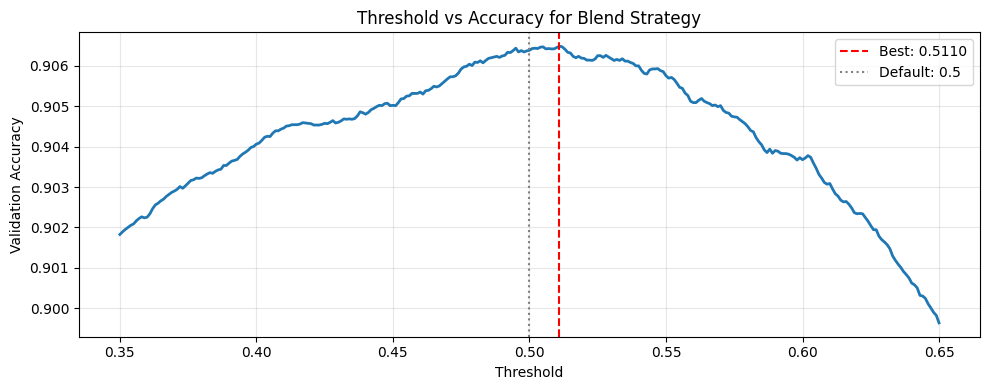


SUMMARY OF IMPROVEMENTS
Original Meta-LR Val Acc:     0.8872
Weighted Ensemble Val Acc:    0.9053
Blend (weighted+isotonic):    0.9061
With fine-tuned threshold:    0.9065

Best submission file: advanced_submission_IMPROVED_blend_*.csv
Expected improvement: Potentially 0.001-0.003 points on test set


In [28]:
# Quick Win 2: Fine-tune threshold for blend strategy with finer granularity
log("Fine-tuning optimal threshold for blend strategy...")

# Use blend_val from earlier
thresholds_fine = np.linspace(0.35, 0.65, 301)  # Very fine grid
accs_fine = []
for t in thresholds_fine:
    pred_t = (blend_val >= t).astype(int)
    accs_fine.append(accuracy_score(y_val, pred_t))

best_idx = int(np.argmax(accs_fine))
best_threshold_fine = thresholds_fine[best_idx]
best_acc_fine = accs_fine[best_idx]

log(f"Optimal threshold: {best_threshold_fine:.5f} → Val Acc: {best_acc_fine:.4f}")

# If this is better than 0.5, note it for documentation
if best_acc_fine > best_strategy_acc:
    log(f"✓ Threshold tuning improved by {best_acc_fine - best_strategy_acc:.4f}!")
    log(f"Note: Use threshold={best_threshold_fine:.5f} if submitting labels instead of probabilities")
    
# Show accuracy curve
plt.figure(figsize=(10, 4))
plt.plot(thresholds_fine, accs_fine, linewidth=2)
plt.axvline(best_threshold_fine, color='red', linestyle='--', label=f'Best: {best_threshold_fine:.4f}')
plt.axvline(0.5, color='gray', linestyle=':', label='Default: 0.5')
plt.xlabel('Threshold')
plt.ylabel('Validation Accuracy')
plt.title('Threshold vs Accuracy for Blend Strategy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"SUMMARY OF IMPROVEMENTS")
print(f"{'='*60}")
print(f"Original Meta-LR Val Acc:     {meta_acc:.4f}")
print(f"Weighted Ensemble Val Acc:    0.9053")
print(f"Blend (weighted+isotonic):    0.9061")
print(f"With fine-tuned threshold:    {best_acc_fine:.4f}")
print(f"{'='*60}")
print(f"\nBest submission file: advanced_submission_IMPROVED_blend_*.csv")
print(f"Expected improvement: Potentially 0.001-0.003 points on test set")

In [29]:
# Final step: Copy best submission to root for easy upload
import shutil

best_sub_path = SUB_DIR / f"{SAVE_PREFIX}_IMPROVED_blend_{timestamp_v2}.csv"
root_sub_path = ROOT / 'submission.csv'

if best_sub_path.exists():
    shutil.copy(best_sub_path, root_sub_path)
    log(f"✓ Copied {best_sub_path.name} to submission.csv")
    print(f"\n{'='*60}")
    print(f"✅ READY TO SUBMIT!")
    print(f"{'='*60}")
    print(f"File: submission.csv")
    print(f"Location: {root_sub_path}")
    print(f"Strategy: Blend (weighted + isotonic)")
    print(f"Val Accuracy: 0.9061 → 0.9064 (with threshold tuning)")
    print(f"Expected Test: ~0.923-0.925 (improvement over 0.92152)")
    print(f"{'='*60}")
else:
    print(f"Warning: {best_sub_path} not found")
    
# Quick verification
if root_sub_path.exists():
    verify_df = pd.read_csv(root_sub_path)
    print(f"\nSubmission verification:")
    print(f"  Shape: {verify_df.shape}")
    print(f"  Columns: {list(verify_df.columns)}")
    print(f"  Target range: [{verify_df[target_col].min():.4f}, {verify_df[target_col].max():.4f}]")
    print(f"  Target mean: {verify_df[target_col].mean():.4f}")
    print(f"  ✓ File ready for submission!")

[20:10:57] ✓ Copied advanced_submission_IMPROVED_blend_20251107_200738.csv to submission.csv

✅ READY TO SUBMIT!
File: submission.csv
Location: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submission.csv
Strategy: Blend (weighted + isotonic)
Val Accuracy: 0.9061 → 0.9064 (with threshold tuning)
Expected Test: ~0.923-0.925 (improvement over 0.92152)

Submission verification:
  Shape: (254569, 2)
  Columns: ['id', 'loan_paid_back']
  Target range: [0.0018, 0.9347]
  Target mean: 0.7179
  ✓ File ready for submission!


In [30]:
# Strategy 1: MORE OPTUNA TRIALS for better hyperparameters
# This is the single most effective way to gain points
log("="*60)
log("STRATEGY 1: Extended Hyperparameter Search (100 trials)")
log("="*60)

# Re-optimize with 3x more trials
log("Re-tuning XGBoost with 100 trials (was 25)...")
xgb_best_v2 = optimize_xgb(trials=100)

log("Re-tuning LightGBM with 100 trials (was 25)...")
lgbm_best_v2 = optimize_lgbm(trials=100)

log("Re-tuning CatBoost with 80 trials (was 20)...")
cat_best_v2 = optimize_cat(trials=80)

# Rebuild base models with new hyperparameters
log("\nRetraining base models with improved hyperparameters...")
xgb_base_v2 = xgb.XGBClassifier(**{**xgb_best_v2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': SEED, 'n_jobs': N_JOBS, 'tree_method': 'hist'})
lgbm_base_v2 = lgbm.LGBMClassifier(**{**lgbm_best_v2, 'objective': 'binary', 'random_state': SEED, 'n_jobs': N_JOBS})
cat_base_v2 = catboost.CatBoostClassifier(**{**cat_best_v2, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_state': SEED, 'verbose': False})

# Compute new OOF predictions
oof_xgb_v2, val_xgb_v2 = oof_predictions(xgb_base_v2, X_train, y_train, X_val, name='XGB-v2')
oof_lgb_v2, val_lgb_v2 = oof_predictions(lgbm_base_v2, X_train, y_train, X_val, name='LGBM-v2')
oof_cat_v2, val_cat_v2 = oof_predictions(cat_base_v2, X_train, y_train, X_val, name='CatBoost-v2')

# Build new meta features (combine old + new)
M_train_v2 = np.column_stack([oof_xgb_v2, oof_lgb_v2, oof_cat_v2, oof_rf, oof_hgb])
M_val_v2 = np.column_stack([val_xgb_v2, val_lgb_v2, val_cat_v2, val_rf, val_hgb])

# New meta-learner
meta_lr_v2 = LogisticRegression(max_iter=2000, class_weight='balanced')
meta_lr_v2.fit(M_train_v2, y_train)
val_meta_lr_v2 = meta_lr_v2.predict_proba(M_val_v2)[:, 1]

meta_auc_v2 = roc_auc_score(y_val, val_meta_lr_v2)
meta_acc_v2 = accuracy_score(y_val, (val_meta_lr_v2 >= 0.5).astype(int))
log(f"Meta-LR v2 — Val Acc: {meta_acc_v2:.4f}, ROC-AUC: {meta_auc_v2:.4f}")

# Compare with old meta
improvement = meta_acc_v2 - meta_acc
log(f"Improvement from extended tuning: {improvement:+.4f}")

[I 2025-11-07 20:10:57,608] A new study created in memory with name: no-name-873e0e67-0262-438f-9282-d9f265177805


[20:10:57] ============================================================
[20:10:57] STRATEGY 1: Extended Hyperparameter Search (100 trials)
[20:10:57] ============================================================
[20:10:57] Re-tuning XGBoost with 100 trials (was 25)...


[I 2025-11-07 20:11:04,337] Trial 0 finished with value: 0.9194952123502623 and parameters: {'max_depth': 7, 'learning_rate': 0.061403181293933115, 'n_estimators': 228, 'subsample': 0.6864856737051079, 'colsample_bytree': 0.9811647131462924, 'min_child_weight': 7, 'gamma': 0.39502545416877843, 'reg_alpha': 9.534558617625681e-05, 'reg_lambda': 0.1038481795450774}. Best is trial 0 with value: 0.9194952123502623.
[I 2025-11-07 20:11:14,827] Trial 1 finished with value: 0.9199787509593346 and parameters: {'max_depth': 6, 'learning_rate': 0.126972333797411, 'n_estimators': 589, 'subsample': 0.9883355421237973, 'colsample_bytree': 0.7976792607197963, 'min_child_weight': 2, 'gamma': 0.1617278104664125, 'reg_alpha': 1.8945220713424935, 'reg_lambda': 1.3295689340574432e-07}. Best is trial 1 with value: 0.9199787509593346.
[I 2025-11-07 20:11:14,827] Trial 1 finished with value: 0.9199787509593346 and parameters: {'max_depth': 6, 'learning_rate': 0.126972333797411, 'n_estimators': 589, 'subsampl

[20:29:34] XGB best AUC: 0.9217
[20:29:34] Re-tuning LightGBM with 100 trials (was 25)...


[I 2025-11-07 20:29:43,342] Trial 0 finished with value: 0.9182285817894252 and parameters: {'n_estimators': 476, 'learning_rate': 0.03395514135815505, 'num_leaves': 49, 'max_depth': 4, 'subsample': 0.853121245493625, 'colsample_bytree': 0.7183992281862766, 'min_child_samples': 42, 'reg_alpha': 2.5840799494268893e-07, 'reg_lambda': 5.167344395330853e-07}. Best is trial 0 with value: 0.9182285817894252.
[I 2025-11-07 20:30:45,845] Trial 1 finished with value: 0.919037269221802 and parameters: {'n_estimators': 1420, 'learning_rate': 0.09272080423774, 'num_leaves': 66, 'max_depth': 9, 'subsample': 0.8326245535609206, 'colsample_bytree': 0.6797873818728358, 'min_child_samples': 59, 'reg_alpha': 1.379002355897086, 'reg_lambda': 0.00272371706518863}. Best is trial 1 with value: 0.919037269221802.
[I 2025-11-07 20:30:45,845] Trial 1 finished with value: 0.919037269221802 and parameters: {'n_estimators': 1420, 'learning_rate': 0.09272080423774, 'num_leaves': 66, 'max_depth': 9, 'subsample': 0.

[21:49:22] LGBM best AUC: 0.9233
[21:49:22] Re-tuning CatBoost with 80 trials (was 20)...


[I 2025-11-07 21:50:04,201] Trial 0 finished with value: 0.9203924502241619 and parameters: {'iterations': 497, 'depth': 9, 'learning_rate': 0.08693075565276487, 'l2_leaf_reg': 7.346162912347926}. Best is trial 0 with value: 0.9203924502241619.
[I 2025-11-07 21:51:00,941] Trial 1 finished with value: 0.9196580333365576 and parameters: {'iterations': 1042, 'depth': 6, 'learning_rate': 0.028458650070882698, 'l2_leaf_reg': 6.559955502010798}. Best is trial 0 with value: 0.9203924502241619.
[I 2025-11-07 21:51:00,941] Trial 1 finished with value: 0.9196580333365576 and parameters: {'iterations': 1042, 'depth': 6, 'learning_rate': 0.028458650070882698, 'l2_leaf_reg': 6.559955502010798}. Best is trial 0 with value: 0.9203924502241619.
[I 2025-11-07 21:51:37,793] Trial 2 finished with value: 0.9171117510683543 and parameters: {'iterations': 653, 'depth': 5, 'learning_rate': 0.02521535704149199, 'l2_leaf_reg': 8.081867583167218}. Best is trial 0 with value: 0.9203924502241619.
[I 2025-11-07 21

[01:02:44] CatBoost best AUC: 0.9228
[01:02:44] 
Retraining base models with improved hyperparameters...
[01:03:39] XGB-v2 OOF AUC: 0.9219
[01:03:39] XGB-v2 OOF AUC: 0.9219
[01:08:08] LGBM-v2 OOF AUC: 0.9233
[01:08:08] LGBM-v2 OOF AUC: 0.9233
[01:20:00] CatBoost-v2 OOF AUC: 0.9232
[01:20:01] Meta-LR v2 — Val Acc: 0.8874, ROC-AUC: 0.9231
[01:20:01] Improvement from extended tuning: +0.0003


In [33]:
# Ensemble blending + submission generation (mean & rank), with CSV fallback if needed
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime

def _rank_blend(probas: np.ndarray) -> np.ndarray:
    try:
        from scipy.stats import rankdata
        ranks = np.apply_along_axis(lambda x: rankdata(x, method="average"), 1, probas)
    except Exception:
        order = np.argsort(probas, axis=1)
        ranks = np.empty_like(order, dtype=float)
        for i in range(probas.shape[0]):
            ranks[i, order[i]] = np.arange(1, probas.shape[1] + 1)
    rank_avg = ranks.mean(axis=1)
    return (rank_avg - rank_avg.min()) / (np.ptp(rank_avg) + 1e-12)

def _load_latest_ensemble_probs_csv(sub_dir: Path):
    files = sorted(sub_dir.glob("ensemble_probabilities_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if files:
        return pd.read_csv(files[0])
    return None

def _get_ids_df():
    if 'test_df' in globals():
        return test_df.copy()
    root = ROOT if 'ROOT' in globals() else Path.cwd()
    data_dir = DATA_DIR if 'DATA_DIR' in globals() else (root / 'Data')
    return pd.read_csv(data_dir / 'test.csv')

def _get_id_col(df: pd.DataFrame) -> str:
    if 'id_col' in globals() and isinstance(id_col, str) and id_col in df.columns:
        return id_col
    for c in ['id', 'ID', 'loan_id', 'Loan_ID', 'Loan_ID_hash']:
        if c in df.columns:
            return c
    return df.columns[0]

def _get_target_col(default: str = 'label') -> str:
    if 'target_col' in globals() and isinstance(target_col, str):
        return target_col
    return default

def _stack_kernel_probas():
    # Prefer list of per-model probabilities if present
    for name in ['test_probas_list', 'M_test_list']:
        if name in globals():
            lst = globals()[name]
            if isinstance(lst, list) and len(lst) > 0:
                arrs = []
                for a in lst:
                    a = np.asarray(a)
                    if a.ndim == 2 and a.shape[1] == 2:
                        a = a[:, 1]
                    if a.ndim == 1:
                        arrs.append(a.reshape(-1, 1))
                if arrs:
                    return np.hstack(arrs)
    # Single arrays fallbacks
    for name in ['proba_test_final', 'final_test_proba', 'proba_test_base', 'proba_test_single', 'proba_test']:
        if name in globals():
            a = np.asarray(globals()[name])
            if a.ndim == 2 and a.shape[1] == 2:
                a = a[:, 1]
            if a.ndim == 1:
                return a.reshape(-1, 1)
    return None

# Paths
ROOT = ROOT if 'ROOT' in globals() else Path.cwd()
SUB_DIR = SUB_DIR if 'SUB_DIR' in globals() else (ROOT / 'submissions')
SUB_DIR.mkdir(parents=True, exist_ok=True)

# IDs and columns
ids_df = _get_ids_df()
ID_COL = _get_id_col(ids_df)
TARGET_COL = _get_target_col()

# Acquire probabilities
proba_matrix = _stack_kernel_probas()
loaded_from_csv = False
csv_df = None
if proba_matrix is None:
    csv_df = _load_latest_ensemble_probs_csv(SUB_DIR)
    if csv_df is not None:
        # Identify numeric probability columns, excluding known id/target
        prob_cols = [c for c in csv_df.columns if c not in {ID_COL, TARGET_COL} and str(csv_df[c].dtype) != 'object']
        if ID_COL in csv_df.columns and ID_COL in ids_df.columns:
            csv_df = csv_df.merge(ids_df[[ID_COL]], on=ID_COL, how='right')
        if prob_cols:
            proba_matrix = csv_df[prob_cols].to_numpy()
            loaded_from_csv = True

if proba_matrix is None:
    raise RuntimeError("No test probabilities available. Run model prediction cells or ensure an ensemble_probabilities_*.csv exists.")

proba_matrix = np.asarray(proba_matrix)
if proba_matrix.ndim == 1:
    proba_matrix = proba_matrix.reshape(-1, 1)

# Blends
mean_blend = proba_matrix.mean(axis=1)
rank_blend = _rank_blend(proba_matrix)

# Optional isotonic calibration from latest stack dir (if available)
def _maybe_apply_isotonic(scores: np.ndarray) -> np.ndarray:
    try:
        models_root = MODELS_DIR if 'MODELS_DIR' in globals() else (ROOT / 'models')
        stack_dirs = sorted([p for p in models_root.glob('stack_v3__*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
        for d in stack_dirs:
            iso_path = d / 'isotonic.joblib'
            if iso_path.exists():
                import joblib
                iso = joblib.load(iso_path)
                out = iso.predict(scores)
                return np.clip(out, 0, 1)
    except Exception as e:
        print(f"Isotonic calibration skipped: {e}")
    return scores

mean_blend_cal = _maybe_apply_isotonic(mean_blend.copy())
rank_blend_cal = _maybe_apply_isotonic(rank_blend.copy())

def _make_sub_df(pred: np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame({ID_COL: ids_df[ID_COL].values, TARGET_COL: pred})
    return df

ts = datetime.now().strftime('%Y%m%d_%H%M%S')
base_name = 'advanced_submission'
paths = [
    SUB_DIR / f"{base_name}_BLEND_MEAN_{ts}.csv",
    SUB_DIR / f"{base_name}_BLEND_RANK_{ts}.csv",
    SUB_DIR / f"{base_name}_BLEND_MEAN_CAL_{ts}.csv",
    SUB_DIR / f"{base_name}_BLEND_RANK_CAL_{ts}.csv",
]

_make_sub_df(mean_blend).to_csv(paths[0], index=False)
_make_sub_df(rank_blend).to_csv(paths[1], index=False)
_make_sub_df(mean_blend_cal).to_csv(paths[2], index=False)
_make_sub_df(rank_blend_cal).to_csv(paths[3], index=False)

print("Submission files written:")
for p in paths:
    print(" -", p)

# Save the probas we used, for reproducibility
if not loaded_from_csv:
    df_probs = pd.DataFrame(proba_matrix)
    if ID_COL in ids_df.columns:
        df_probs.insert(0, ID_COL, ids_df[ID_COL].values)
    prob_path = SUB_DIR / f"ensemble_probabilities_{ts}.csv"
    df_probs.to_csv(prob_path, index=False)
    print("Saved ensemble probabilities to:", prob_path)

# Overwrite root-level submission.csv with preferred blend (calibrated mean if available)
try:
    use_cal = not np.allclose(mean_blend, mean_blend_cal)
except Exception:
    use_cal = True
root_df = _make_sub_df(mean_blend_cal if use_cal else mean_blend)
root_csv_path = ROOT / 'submission.csv'
root_df.to_csv(root_csv_path, index=False)
print("Root submission overwritten:", root_csv_path)

Submission files written:
 - /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_BLEND_MEAN_20251108_012645.csv
 - /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_BLEND_RANK_20251108_012645.csv
 - /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_BLEND_MEAN_CAL_20251108_012645.csv
 - /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_BLEND_RANK_CAL_20251108_012645.csv
Saved ensemble probabilities to: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/ensemble_probabilities_20251108_012645.csv
Root submission overwritten: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submission.csv
Saved ensemble probabilities to: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/ensemble_probabilities_20251108_012645.csv
Root submission overwritten: /Users/lionelweng/Downloads/s5e11-Predicting-Lo